In [12]:
import os
import numpy as np
import tensorflow.keras.preprocessing.image as img_preproc
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps
from models import get_model
import json
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

input_dir = "/data/datasets/MoNuSAC_images_and_annotations/"
target_dir = "/data/datasets/MoNuSAC_bin_masks/"
img_size = (160, 160)
num_classes = 5
batch_size = 8

with open('/data/datasets/processed_dataset.json', 'r') as file:
    dataset = json.load(file)

input_img_paths = dataset['images']    
target_img_paths = dataset['masks']
    
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    
assert len(input_img_paths)>0,"input_dir is empty"
assert len(input_img_paths)>0,"target_dir is empty"

Number of samples: 3225
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_00.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_mask_00.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_01.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_mask_01.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_10.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_mask_10.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_11.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-1_mask_11.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_00.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_mask_00.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_01.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_mask_01.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_10.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_mask_10.npy
TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_11.tif | TCGA-X4-A8KQ-01Z-00-DX8/TCGA-X4-A8KQ-01Z-00-DX8-2_mask_11.npy
TCGA-X4-

In [13]:
import matplotlib.pyplot as plt

In [14]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
import random
from dataset import Challenge

# Split our img paths into a training and a validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_img_paths, 
                                                    target_img_paths, 
                                                    test_size=0.10, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.10, random_state=42)

# Instantiate data Sequences for each split
train_gen = Challenge(
    batch_size, img_size, input_dir, target_dir, X_train, y_train, shuffle=False, augment=False
)
val_gen = Challenge(
    batch_size, img_size, input_dir, target_dir, X_val, y_val, shuffle=False, augment=False
)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

metrics = ['accuracy']

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=metrics)

In [18]:
callbacks = [
    ModelCheckpoint("monusac-challenge_segmentation_baseline.h5", save_best_only=True),
    EarlyStopping(min_delta=0.01, patience=10, restore_best_weights=True, verbose=1)
]

# Train the model for 50 epochs, in reality it will stop earlier because of the EarlyStopping
epochs = 10
history = model.fit(train_gen, 
                    epochs=epochs, 
                    validation_data=val_gen, 
                    callbacks=callbacks)

Epoch 1/10
326/326 [==============================] - 239s 734ms/step - loss: 0.5633 - accuracy: 0.8668 - val_loss: 0.5323 - val_accuracy: 0.9896
Epoch 2/10
326/326 [==============================] - 237s 729ms/step - loss: 0.3358 - accuracy: 0.8586 - val_loss: 0.3328 - val_accuracy: 0.8088
Epoch 3/10
326/326 [==============================] - 237s 728ms/step - loss: 0.3074 - accuracy: 0.8535 - val_loss: 0.3291 - val_accuracy: 0.8529
Epoch 4/10
326/326 [==============================] - 238s 729ms/step - loss: 0.2835 - accuracy: 0.8498 - val_loss: 0.2637 - val_accuracy: 0.8361
Epoch 5/10
326/326 [==============================] - 237s 727ms/step - loss: 0.2631 - accuracy: 0.8468 - val_loss: 0.2897 - val_accuracy: 0.9014
Epoch 6/10
326/326 [==============================] - 238s 731ms/step - loss: 0.2467 - accuracy: 0.8437 - val_loss: 0.2567 - val_accuracy: 0.8405
Epoch 7/10
326/326 [==============================] - 237s 726ms/step - loss: 0.2287 - accuracy: 0.8406 - val_loss: 0.2727 -

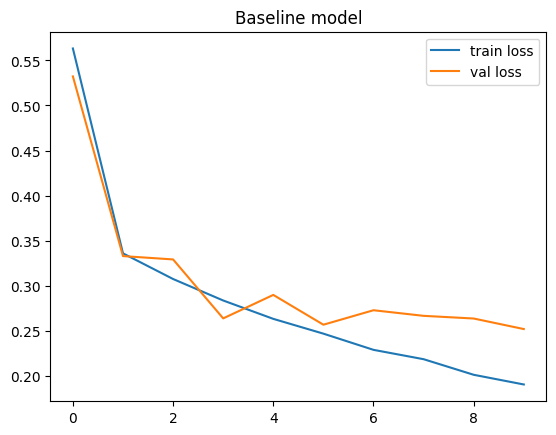

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc="upper right")
plt.title("Baseline model")
plt.show()

# Model evaluation - validation set

In [26]:
from segmentation_metrics import calculate_metrics
import cv2

val_gen = Challenge(
    1, img_size, input_dir, target_dir, X_val, y_val, shuffle=False, augment=False
)

val_preds = model.predict(val_gen)

In [30]:
y = np.zeros((len(X_val),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(y_val):
    #mask = np.array(load_img(mask_path, target_size=img_size, color_mode="grayscale"))
    mask = np.load(os.path.join(target_dir, mask_path))
    if (mask.shape[0],mask.shape[1]) != img_size:
        mask = cv2.resize(mask, dsize=img_size, interpolation=cv2.INTER_NEAREST_EXACT)
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [31]:
y = np.squeeze(y)
pr_masks = np.argmax(val_preds, axis=-1)
y.shape, pr_masks.shape

((291, 160, 160), (291, 160, 160))

In [32]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

In [41]:
calculate_metrics(y, val_preds)

Accuracy: 0.9106239080429077


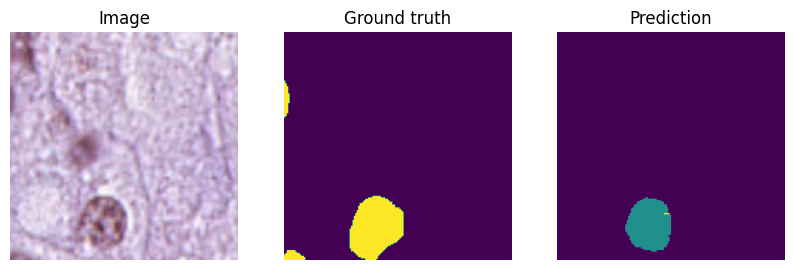

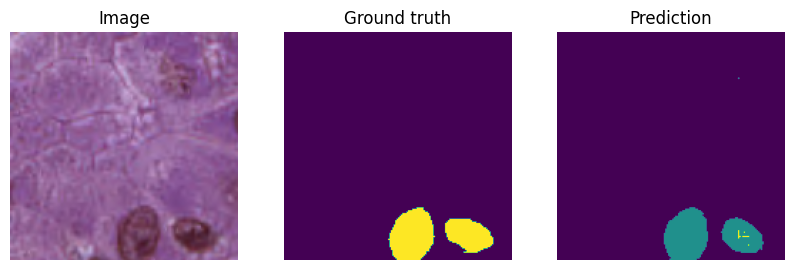

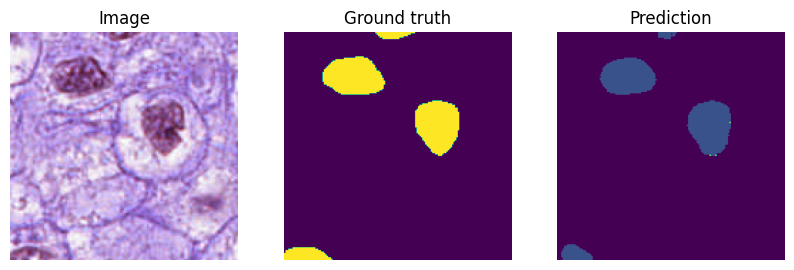

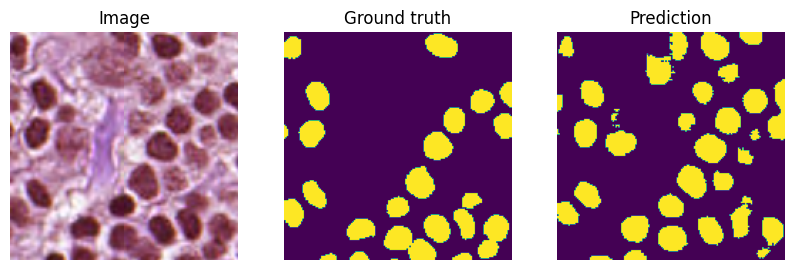

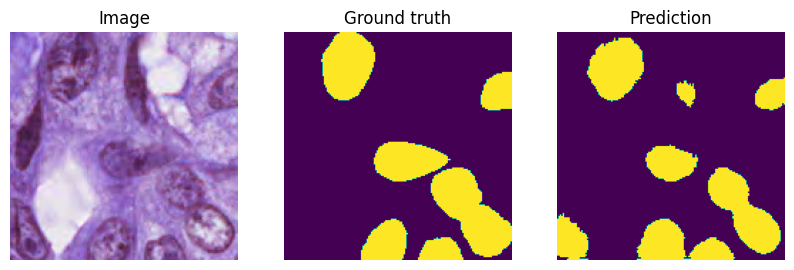

In [35]:
max_img = 5
pr_masks = np.argmax(val_preds, axis=-1)
    
for img_path, mask_path, pr_mask in zip(X_val[:max_img], 
                                        y_val[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(os.path.join(input_dir,img_path), target_size=img_size)
    mask = np.load(os.path.join(target_dir, mask_path))
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Model evaluation - Test set

In [43]:
test_gen = Challenge(
    1, img_size, input_dir, target_dir, X_test, y_test, shuffle=False, augment=False
)

In [44]:
test_preds = model.predict(test_gen)

### load all masks as used in training to calculate metrics

In [45]:
y = np.zeros((len(X_test),) + img_size + (1,), dtype="uint8")
for i, mask_path in enumerate(y_test):
    mask = np.load(os.path.join(target_dir, mask_path))
    if (mask.shape[0],mask.shape[1]) != img_size:
        mask = cv2.resize(mask, dsize=img_size, interpolation=cv2.INTER_NEAREST_EXACT)
    mask = np.expand_dims(mask, 2)
    y[i] = mask

In [46]:
y = np.squeeze(y)
pr_masks = np.argmax(test_preds, axis=-1)
y.shape, pr_masks.shape

((323, 160, 160), (323, 160, 160))

In [47]:
assert y.shape==pr_masks.shape, "number of test samples doesn't match predictions"

In [48]:
calculate_metrics(y, test_preds)

Accuracy: 0.909567654132843


## Visualization

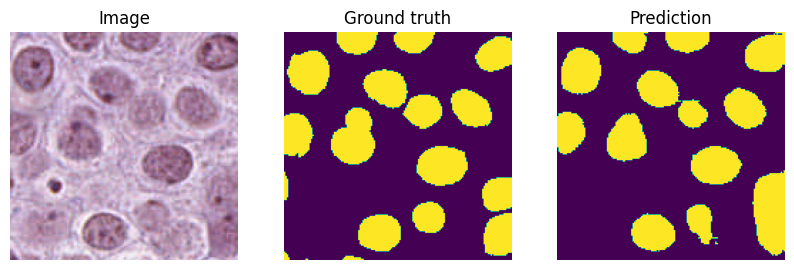

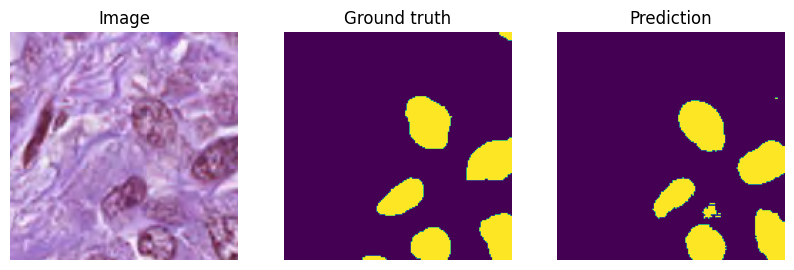

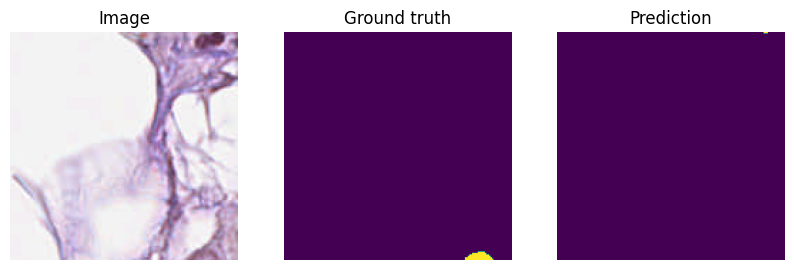

In [49]:
max_img = 3
    
for img_path, mask_path, pr_mask in zip(X_test[:max_img], 
                                        y_test[:max_img], 
                                        pr_masks[:max_img]):
    plt.figure(figsize=(10, 5))

    img = load_img(os.path.join(input_dir,img_path), target_size=img_size)
    mask = np.load(os.path.join(target_dir, mask_path))
    prediction = np.expand_dims(pr_mask, axis=-1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(img))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(np.array(mask)) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()